In [2]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install opencv-python

In [2]:
import os
import cv2
import numpy as np
import time
import matplotlib.image as impl
import matplotlib.pyplot as plt
from scipy.ndimage import generic_filter
from sklearn.metrics import roc_curve,classification_report,accuracy_score

#Create directories to save output images

if not os.path.exists('noise_removed_img'):
    os.makedirs('noise_removed_img')

#Paths to the data

RGB_path='Images'
ground_truth_path='BakSubGroundTruth'


--- Processing for Lambda = 0.5 ---
Total Time = 115.87 seconds
              precision    recall  f1-score   support

           0       1.00      0.00      0.00  49676245
           1       0.04      1.00      0.08   2267435

    accuracy                           0.05  51943680
   macro avg       0.52      0.50      0.04  51943680
weighted avg       0.96      0.05      0.01  51943680

Accuracy = 4.59%

--- Processing for Lambda = 1.0 ---
Total Time = 101.62 seconds
              precision    recall  f1-score   support

           0       1.00      0.00      0.01  49676245
           1       0.04      1.00      0.08   2267435

    accuracy                           0.05  51943680
   macro avg       0.52      0.50      0.04  51943680
weighted avg       0.96      0.05      0.01  51943680

Accuracy = 4.61%

--- Processing for Lambda = 2.0 ---


KeyboardInterrupt: 

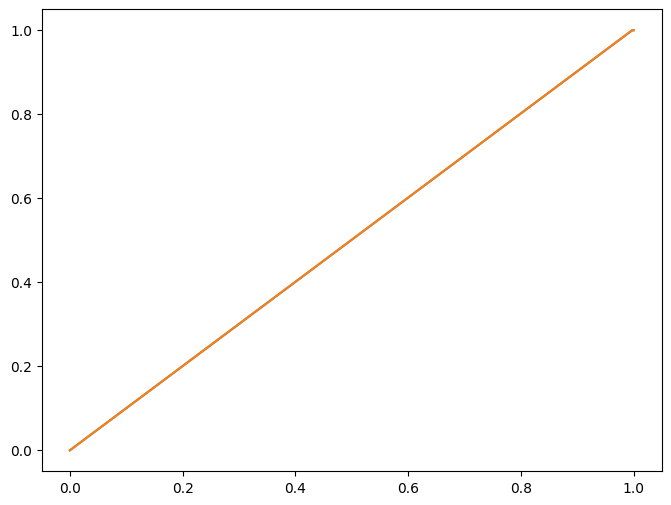

In [3]:
#@title Solution

lambda_val = np.array([0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0])
plt.figure(figsize=(8, 6))

for l in lambda_val:
    print(f'\n--- Processing for Lambda = {l} ---')
    start_time = time.time()

    try:
        files = sorted(os.listdir(RGB_path))
        if not files:
            print(f"Error: The directory '{RGB_path}' is empty or not found.")
            print("Please make sure you have uploaded the 'Images' folder.")
            continue
    except FileNotFoundError:
        print(f"Error: The directory '{RGB_path}' was not found.")
        print("Please make sure you have uploaded the 'Images' folder.")
        break

    # =============================================================================
    # 1. Initialization
    # We initialize the background model using the first frame.
    # =============================================================================
    v_d = 9.0
    m = 5
    eta = 0.6
    t_c = 100
    t = 0

    # M1: Mean of the background model. Initialized with the first image.
    first_image_path = os.path.join(RGB_path, files[0])
    M1 = impl.imread(first_image_path).astype(np.float64)

    rows, columns, channels = M1.shape

    # V1: Variance of the background model. Initialized with the default variance v_d.
    V1 = np.full_like(M1, v_d, dtype=np.float64)

    Y_actual_flat = []
    Y_predicted_flat = []
    lambda_sq = l ** 2

    for img_file in files:
        img_path = os.path.join(RGB_path, img_file)
        image = impl.imread(img_path).astype(np.float64)
        t += 1

        # =============================================================================
        # 2. Foreground Detection
        # Formula: C_t(x,y) is 0 if D_t^2 <= λ^2 * V_{t-1} for all 3 channels.
        # =============================================================================
        distance = image - M1
        is_background_per_channel = (distance ** 2) <= (lambda_sq * V1)

        # A pixel is background (True) only if it's background in ALL channels.
        is_background_mask = np.all(is_background_per_channel, axis=2)

        # Convert boolean mask to binary image: Foreground=255, Background=0
        foreground_mask_initial = np.where(is_background_mask, 0, 255).astype(np.uint8)

        # =============================================================================
        # 3. Noise Removal (Optimized)
        # Formula: A pixel is foreground if the proportion of foreground pixels
        # in its m x m neighborhood is >= eta.
        # =============================================================================
        def filter_func(neighborhood):
            return 1 if np.count_nonzero(neighborhood) / (m*m) >= eta else 0

        # We normalize the image to 0s and 1s for easier counting.
        normalized_mask = foreground_mask_initial / 255.0
        filtered_mask_normalized = generic_filter(normalized_mask, filter_func, size=m)

        # Convert back to 0 and 255.
        noise_removed_img = (filtered_mask_normalized * 255).astype(np.uint8)
        plt.imsave(f'noise_removed_img/{l}_{img_file}', noise_removed_img, cmap='gray')

        # =============================================================================
        # 4. Background Model Update
        # The model (M1 and V1) is updated only for pixels identified as background.
        # =============================================================================
        # Create a mask where background pixels are True.
        update_mask = (noise_removed_img == 0)
        # Reshape for broadcasting across the 3 color channels.
        update_mask_3d = np.stack([update_mask] * channels, axis=-1)

        # Calculate learning rate alpha_t
        alpha = 1.0 / t if t <= t_c else 1.0 / t_c

        # Update Mean M1
        # Formula: M_t = M_{t-1} + alpha_t * D_t (only for background pixels)
        M1[update_mask_3d] += (alpha * distance[update_mask_3d])

        # Update Variance V1
        # Formula: V_t = (1 - alpha_t) * V_{t-1} + alpha_t * D_t^2 (for background)
        # For foreground pixels, V_t remains V_{t-1}.
        term1 = (1 - alpha) * V1[update_mask_3d]
        term2 = alpha * (distance[update_mask_3d] ** 2)
        V1[update_mask_3d] = term1 + term2

        # =============================================================================
        # 5. Evaluation
        # Compare the result with the ground truth image.
        # =============================================================================
        try:
            g_file = 'groundMono' + img_file.split('_')[1]
            groundtruth_path_full = os.path.join(ground_truth_path, g_file)
            y_true = cv2.imread(groundtruth_path_full, 0)
            # Normalize to 0 (background) and 1 (foreground)
            y_true = np.where(y_true == 255, 1, 0)
            y_predict = np.where(noise_removed_img == 255, 1, 0)

            Y_actual_flat.extend(y_true.ravel())
            Y_predicted_flat.extend(y_predict.ravel())
        except (FileNotFoundError, IndexError):
            # This handles cases where a ground truth file might be missing
            # or the filename format is unexpected.
            print(f"Warning: Could not find or parse ground truth for {img_file}")
            continue

    # =============================================================================
    # 6. Reporting and Plotting for the current Lambda
    # =============================================================================
    if not Y_actual_flat or not Y_predicted_flat:
        print("No ground truth data was processed. Skipping metrics.")
        continue

    fpr, tpr, thresholds = roc_curve(Y_actual_flat, Y_predicted_flat)
    plt.plot(fpr, tpr, label=f'λ = {l}')

    print(f"Total Time = {(time.time() - start_time):.2f} seconds")
    print(classification_report(Y_actual_flat, Y_predicted_flat))
    print(f'Accuracy = {accuracy_score(Y_actual_flat, Y_predicted_flat) * 100:.2f}%')

plt.legend(loc="lower right")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Background Subtraction')
plt.grid(True)
plt.show()